In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import fastreg.linear as frl
import fastreg.general as frg
%matplotlib inline

### Generate Data

In [10]:
st = np.random.RandomState(89320432)
N, K1, K2 = 100_000, 10, 100

In [11]:
df0 = pd.DataFrame({
    'id1': st.randint(K1, size=N),
    'id2': st.randint(K2, size=N),
    'x1': st.randn(N),
    'x2': st.randn(N)
})
df0['y'] = 5 + 3*df0['x1'] + 2*df0['x2'] + st.randn(N)
df0['lEp'] = 0.6*df0['x1'] + 0.2*df0['x2']
df0['Ep'] = np.exp(df0['lEp'])
df0['p'] = np.random.poisson(df0['Ep'])
df0['p0'] = np.where(st.rand(N) < 0.2, 0, df0['p'])
df0.head()

,id1,id2,x1,x2,y,lEp,Ep,p,p0
0,4,37,-0.259664,0.957506,5.679871,0.035703,1.036348,2,2
1,8,65,0.334285,-1.045791,3.786864,-0.008587,0.991449,1,1
2,8,10,0.067322,-0.631068,3.515400,-0.085820,0.917759,0,0
3,8,10,0.384297,0.485393,6.381056,0.327657,1.387713,1,0
4,6,38,-1.584996,-1.037097,-2.523866,-1.158417,0.313983,0,0


In [12]:
df = pd.DataFrame({
    'id1': st.randint(K1, size=N),
    'id2': st.randint(K2, size=N),
    'x1': st.randn(N),
    'x2': st.randn(N)
})
df['y'] = 5 + 3*df['x1'] + 2*df['x2'] + 0.1*df['id1'] + 0.01*df['id2'] + st.randn(N)
df['lEp'] = 0.6*df['x1'] + 0.2*df['x2'] + 0.2*df['id1']/100 + 0.5*df['id2']/100
df['Ep'] = np.exp(df['lEp'])
df['p'] = np.random.poisson(df['Ep'])
df.head()

,id1,id2,x1,x2,y,lEp,Ep,p
0,6,73,1.523574,0.217466,10.722923,1.334637,3.798618,3
1,7,5,-0.477160,0.992419,6.810419,-0.048812,0.952360,1
2,4,46,-0.720889,0.157152,4.179312,-0.163103,0.849504,1
3,3,38,1.738053,0.770928,13.797231,1.393017,4.026982,2
4,0,63,0.035853,-0.380131,4.577832,0.260486,1.297560,3


### Normal OLS

In [96]:
%time smf.ols('y ~ x1 + x2', data=df).fit().params

CPU times: user 825 ms, sys: 642 ms, total: 1.47 s
Wall time: 336 ms


Intercept    5.945739
x1           3.001904
x2           1.998668
dtype: float64

In [97]:
%time frl.ols(y='y', x=['x1', 'x2'], data=df)

CPU times: user 101 ms, sys: 53.2 ms, total: 154 ms
Wall time: 58.3 ms


,coeff,stderr,low95,high95,pvalue
intercept,5.945739,0.001080,5.943622,5.947857,0.0
x1,3.001904,0.001080,2.999788,3.004021,0.0
x2,1.998668,0.001079,1.996552,2.000783,0.0


### Sparse OLS

In [98]:
%time frl.ols(y='y', x=['x1', 'x2'], fe=['id1', 'id2'], data=df)

CPU times: user 1.02 s, sys: 57.1 ms, total: 1.07 s
Wall time: 1.08 s


,coeff,stderr,low95,high95,pvalue
intercept,4.990156,0.010465,4.969644,5.010667,0.0
x1,3.001682,0.001000,2.999721,3.003642,0.0
x2,1.998036,0.001000,1.996077,1.999995,0.0
id1=1,0.099544,0.004481,0.090761,0.108327,0.0
id1=2,0.195235,0.004484,0.186447,0.204023,0.0
...,...,...,...,...,...
id2=95,0.955351,0.014152,0.927614,0.983089,0.0
id2=96,0.960740,0.014173,0.932961,0.988519,0.0
id2=97,0.980918,0.014169,0.953146,1.008689,0.0
id2=98,0.996677,0.014184,0.968876,1.024477,0.0


In [99]:
%time frl.ols(y='y', x=['x1', 'x2'], absorb=('id1', 'id2'), data=df0)

CPU times: user 2.13 s, sys: 515 ms, total: 2.65 s
Wall time: 1.77 s


,coeff,stderr,low95,high95,pvalue
intercept,5.002158,0.000001,5.002156,5.002161,0.0
x1,3.000770,0.001016,2.998779,3.002761,0.0
x2,2.000206,0.001033,1.998181,2.002231,0.0


### Poisson

In [13]:
%time frg.poisson(y='p', x=['x1', 'x2'], data=df0, epochs=3)[0]

  0: loss = 0.7781351208686829
  1: loss = 0.7361311316490173
  2: loss = 0.7361311316490173
CPU times: user 8.3 s, sys: 4.98 ms, total: 8.31 s
Wall time: 2.77 s


,coeff,stderr,low95,high95,pvalue
intercept,-0.005621,0.003356,-0.012198,0.000956,0.046956
x1,0.603686,0.002850,0.598099,0.609273,0.000000
x2,0.192795,0.002825,0.187258,0.198333,0.000000


In [26]:
%time table, beta, sigma = frg.poisson(y='p', x=['x1', 'x2'], fe=['id1', 'id2'], data=df, epochs=10)

  0: loss = 0.5476676821708679
  1: loss = 0.5198169946670532
  2: loss = 0.5168352723121643
  3: loss = 0.5148505568504333
  4: loss = 0.5135260224342346
  5: loss = 0.5126403570175171
  6: loss = 0.512046754360199
  7: loss = 0.511647641658783
  8: loss = 0.5113784670829773
  9: loss = 0.5111960172653198
CPU times: user 40.8 s, sys: 140 ms, total: 40.9 s
Wall time: 7.99 s


In [27]:
coeff = table['coeff'].filter(regex='id2').rename('beta1').rename_axis('id2').reset_index()
coeff['id2'] = coeff['id2'].apply(lambda s: s[4:]).astype(np.int)
coeff['beta0'] = 0.5*coeff['id2']/100
coeff['beta1'] += table.loc['intercept', 'coeff']

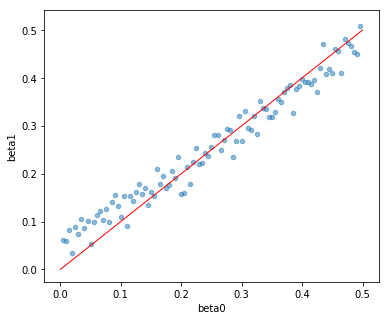

In [28]:
bmax = 0.5*K2/100
beta = np.linspace(0, bmax, 1000)
fig, ax = plt.subplots(figsize=(6, 5))
coeff.plot.scatter(x='beta0', y='beta1', ax=ax, alpha=0.5);
ax.plot(beta, beta, c='r', linewidth=1, zorder=1);